In [25]:
import torch
from ANARX import ANARX, LAGNET
from utilities import lag_matrix
#%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from tqdm import tqdm
from pathlib import Path
print(Path.cwd())

c:\Users\vh\Documents\Projektmodul\Valentin macht alles neu\unified


In [40]:
model = torch.load("sanarx_14_5_test.pt")
data = scipy.io.loadmat("data/1803")
input = data["u2_t"]
out = data["y_t"]

In [27]:
INPUT_LAGS = 5
OUTPUT_LAGS = 14

In [44]:
out = torch.Tensor(out).squeeze()
input = torch.Tensor(input).squeeze()
in_lagged = lag_matrix(input, INPUT_LAGS)
out_lagged = lag_matrix(out, OUTPUT_LAGS)

In [51]:
sinewave = np.sin(np.arange(0, 60, 0.01))
step = np.concatenate((np.zeros(2000), .3*np.ones(2000), np.zeros(2000)))
# plt.plot(sinewave)
# plt.show()

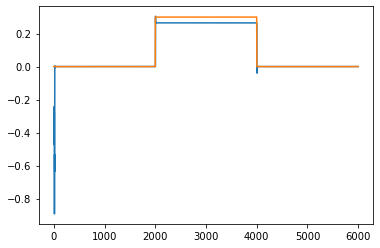

In [57]:
y_hat = model.justpredict([controlled_input])
plt.plot(y_hat[1980:2200])
# plt.plot(out)
plt.plot(step[1980:2200])
plt.show()

In [31]:
x = torch.zeros(model.n_subnets).float()

def nextState(x, u):
    inputs = []
    for i in range(model.n_subnets):
        if model.lag_map[i][0] == 1:
            inputs.append(torch.cat((torch.unsqueeze(u, dim=0), torch.unsqueeze(x[0], dim=0))))
        else:
            inputs.append(torch.unsqueeze(x[0], dim=0))
            
    next = torch.zeros(model.n_subnets)
    for i in range(model.n_subnets-1):
        next[i] = x[i+1] + model.subnets[i](inputs[i])
    next[model.n_subnets-1] =  model.subnets[model.n_subnets - 1](inputs[model.n_subnets-1])
    return next
y = []
for i in tqdm(range(6000)):
    y.append(x[0].detach().numpy())
    x = nextState(x, input[i])

100%|██████████| 6000/6000 [00:19<00:00, 304.01it/s]


Torch Linear Funktion:

$ \eta_1(t) = \left[u(t), y(t)\right]^T\cdot A^T + b $ bzw.
$ u(t)\cdot a_1 + y(t) \cdot a_2 + b = \eta_1(t)$

dannn lässt sich u(t) invers bestimmen:
$ u(t) = \dfrac{\eta_1(t)-y(t)\cdot a_2 - b}{a_1}$

In [33]:
a1 = model.subnets[0].linear_layers[0].weight[0,0]
a2 = model.subnets[0].linear_layers[0].weight[0,0]
b = model.subnets[0].linear_layers[0].bias

In [52]:
x = torch.zeros(model.n_subnets).float()
controlled_input = torch.zeros_like(input)
eta = torch.zeros(model.n_subnets).float()


def nextState(x, u):
    inputs = []
    #print(model.lag_map)
    for i in range(model.n_subnets):
        if model.lag_map[i][0] == 1:
            inputs.append(torch.cat((torch.unsqueeze(u, dim=0), torch.unsqueeze(x[0], dim=0))))
        else:
            inputs.append(torch.unsqueeze(x[0], dim=0))
    # print(inputs)

    next = torch.zeros(model.n_subnets)
    for i in range(model.n_subnets-1):
        next[i] = x[i+1] + model.subnets[i](inputs[i])
    next[model.n_subnets-1] =  model.subnets[model.n_subnets - 1](inputs[model.n_subnets-1])
    return next
y = []
for i in tqdm(range(6000)):
    y.append(x[0].detach().numpy())
    controlled_input[i] = (step[i]-x[1] - torch.Tensor(x[0]) * a2 - b)/a2
    x = nextState(x, controlled_input[i])

100%|██████████| 6000/6000 [00:20<00:00, 290.06it/s]


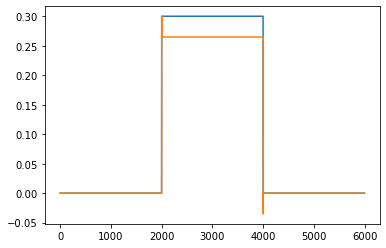

In [56]:
# plt.plot(controlled_input.detach().numpy())
plt.plot(step)
plt.plot(y)
